## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2023-12-23 12:03:30--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-12-23 12:03:30 (7.23 MB/s) - ‘onegin.txt’ saved [262521/262521]



In [3]:
text[:10]

['\n',
 'I\n',
 '\n',
 '«Мой дядя самых честных правил,\n',
 'Когда не в шутку занемог,\n',
 'Он уважать себя заставил\n',
 'И лучше выдумать не мог.\n',
 'Его пример другим наука;\n',
 'Но, боже мой, какая скука\n',
 'С больным сидеть и день и ночь,\n']

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

out - строка, чтобы найти все токены в текстах,
poems_list - массив, где хранятся отдельные стихи

поскольку в исходном текстовом файле много пустых строк, номерации текстов и прочего бесполезного, пришлось писать много if, чтобы почистить текст от них

In [4]:
out = ''
poem=0
poems_list=[]
poems_list_small=''
for i in range(len(text[:-1])):
  if len(text[i])<11:
    if len(text[i])==1:
      pass
    elif len(text[i])>1 and len(text[i])<11:
      poem = 1
  if poem==1 and len(text[i])>10:
    out = out  + text[i].lower()
    poem = 0
    poems_list_small+=  text[i].lower()
  elif poem==0 and len(text[i])>1 and len(text[i+1])==1:
    out = out + text[i].strip().lower()
    poems_list_small+=text[i].lower()
    poems_list.append(poems_list_small)
    poems_list_small=''

  elif poem==0 and len(text[i])>1:
    out = out + text[i].lower()
    poems_list_small+=text[i].lower()
out

'«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»так думал молодой повеса,\nлетя в пыли на почтовых,\nвсевышней волею зевеса\nнаследник всех своих родных. —\nдрузья людмилы и руслана!\nс героем моего романа\nбез предисловий, сей же час\nпозвольте познакомить вас:\nонегин, добрый мой приятель,\nродился на брегах невы,\nгде, может быть, родились вы\nили блистали, мой читатель;\nтам некогда гулял и я:\nно вреден север для меняслужив отлично-благородно,\nдолгами жил его отец,\nдавал три бала ежегодно\nи промотался наконец.\nсудьба евгения хранила:\nсперва madame за ним ходила,\nпотом monsieur ее сменил;\nребенок был резов, но мил.\nmonsieur l’abbe€, француз уб

In [5]:
print(poems_list[3])

когда же юности мятежной
пришла евгению пора,
пора надежд и грусти нежной,
monsieur прогнали со двора.
вот мой онегин на свободе;
острижен по последней моде;
как dandy лондонский одет —
и наконец увидел свет.
он по-французски совершенно
мог изъясняться и писал;
легко мазурку танцевал
и кланялся непринужденно;
чего ж вам больше? свет решил,
что он умен и очень мил.



Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(out))
tokens.append('_') # <PAD>
tokens.append('<') # <SOS>
tokens.append('>') # <EOS>
len(tokens)

86

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
token_index = {idx: token for idx, token in enumerate(tokens)}

# dict <char>:<index>
token_char = {token: idx for idx, token in enumerate(tokens)}

In [8]:
def to_matrix_grenzed(
    names, max_len=None, pad=token_char['_'], dtype='int32', batch_first=True
    ):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, names))

    max_len += 1
    names_ix = np.zeros([len(names), max_len], dtype)

    names_ix[:, 0] = token_char['<'] # <SOS>

    for i in range(len(names)):

        line_ix = [token_char[c] for c in names[i]]
        grenze = min(max_len, len(line_ix))
        names_ix[i, 1:grenze-1] = line_ix[1:grenze-1]
        names_ix[i, grenze-1] = token_char['>'] # <EOS>


    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [9]:
to_matrix_grenzed(poems_list,  max_len=101)[33], token_index[1]

(array([84, 50, 63, 12,  1, 61, 45, 58, 59,  1, 68, 64, 47, 62, 63, 47, 45,
         1, 47,  1, 58, 50, 57,  1, 59, 62, 63, 72, 56, 53, 13,  0, 50, 57,
        64,  1, 58, 45, 62, 55, 64, 68, 53, 56,  1, 62, 47, 50, 63, 45,  1,
        69, 64, 57, 13,  0, 55, 61, 45, 62, 45, 47, 53, 67, 72,  1, 58, 50,
         1, 49, 59, 56, 48, 59,  1, 46, 72, 56, 53,  0, 60, 61, 50, 49, 57,
        50, 63,  1, 50, 48, 59,  1, 60, 61, 53, 47, 72, 68, 58, 72, 66, 85],
       dtype=int32),
 ' ')

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F
from random import sample

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [11]:
num_tokens = len(tokens)

class CharRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=128, rnn_num_units=200):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden=None):

        h_seq, hidden = self.rnn(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden


model = CharRNN()
model.to(device)
opt = torch.optim.Adam(model.parameters())
history = []
loss_func = nn.NLLLoss(ignore_index=token_char['_'])

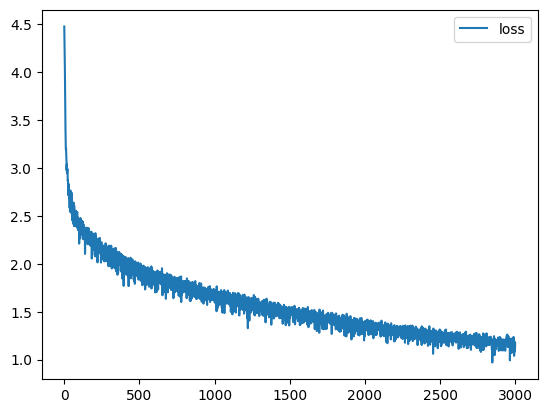

In [12]:
#MAX_LENGTH = max(map(len, names))

for i in range(3000):
    batch_ix = to_matrix_grenzed(sample(poems_list, 32), 200)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    logp_seq, hidden = model(batch_ix)

    # compute loss
    #predictions_logp = logp_seq[:, 1:].contiguous().view(-1, num_tokens)
    #actual_next_tokens = batch_ix[:, :-1].contiguous().view(-1)
    #print(predictions_logp.shape, actual_next_tokens.shape)

    #loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    #print(predictions_logp.shape, actual_next_tokens.shape)
    loss = loss_func(
    predictions_logp.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [13]:
loss_rnn = history[-1]
loss_rnn

1.170620322227478

In [14]:
def generate_sample_rnn(char_rnn, seed_phrase, max_length, temperature=1.0):

    x_sequence = [token_char[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden = torch.zeros(1,  200).to(device)


    # Process the seed phrase if it's longer than one character
    for i in range(len(seed_phrase) - 1):
        _, hidden = char_rnn(x_sequence[:, i], hidden)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logits_next, hidden = char_rnn(x_sequence[:, -1], hidden)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1).to(device)
        if next_ix == token_char['>']:
          break
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [15]:
print(generate_sample_rnn(model,seed_phrase='<а',max_length=500, temperature=0.2))

<ак он проченье, опроча
в таня в таню вы не прочит; вот слова тоть одна его подъезжа;
толпа ленский поверелый,
все досада страдань
свою деревнялись в этой
не видит к ней на старанье,
другой подъемла привы, ла евгений, —
и невым собранье
завез теперь и следа,
в сенье, перешние полейки, принят и душого труда,
простите,
в деревне мог он произвилась в глуши, длужной
она нежностью разумят в постеле не всех страстей,
но своей своей страстный роман
его приятельной дубровой день
его не в том уверить и п


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size=num_tokens, hidden_size=200, embedding_size=128, n_layers=2):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, input_size)

    def forward(self, x, hidden=None):

        h_seq, hidden = self.lstm(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden

model2 = LSTM()
model2.to(device)
opt = torch.optim.Adam(model2.parameters())
history = []
loss_func = nn.NLLLoss(ignore_index=token_char['_'])

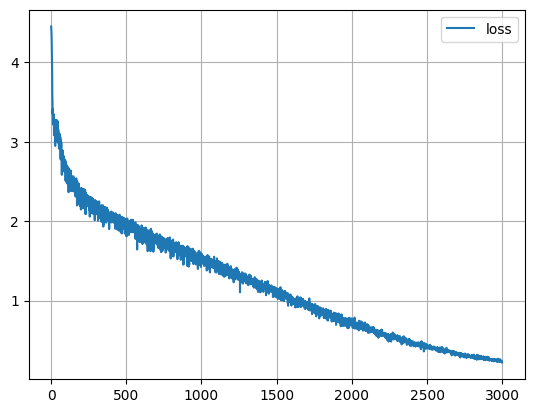

In [17]:
for i in range(3000):
    batch_ix = to_matrix_grenzed(sample(poems_list, 32), 200)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    logp_seq, hidden = model2(batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    #print(predictions_logp.shape, actual_next_tokens.shape)
    loss = loss_func(
    predictions_logp.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.item())
    if (i + 1) % 10 == 0:
        plt.rcParams['axes.grid'] = True
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [18]:
loss_lstm = history[-1]
loss_lstm

0.2218891978263855

In [49]:
def generate_sample_lstm(char_rnn, seed_phrase, max_length, temperature=1.0):

    x_sequence = [token_char[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden1 = torch.zeros(2,  200).to(device)
    hidden2 = torch.zeros(2,  200).to(device)

    # Process the seed phrase if it's longer than one character
    for i in range(len(seed_phrase) - 1):
        _, (hidden1, hidden2) = char_rnn(x_sequence[:, i], (hidden1, hidden2))

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logits_next, (hidden1, hidden2) = char_rnn(x_sequence[:, -1], (hidden1, hidden2))
        p_next = F.softmax(logits_next / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1).to(device)
        if next_ix == token_char['>']:
          break
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [50]:
print(generate_sample_lstm(model2,seed_phrase='<а',max_length=500, temperature=0.2))

<ак он писал темно и вяло
предала татьяна в хлубоком
с садитс о видь по стали трепет
презред ними письтонет
и уставит он устражена
скаким тесний крылек она.
домала на тебнею. —
«как вот отстнал бранил станилась
и всех создно возврата своя
скаках заслучло вечером,
в увлыд, и тум однаньем,
быть мое, вемь евгеним я.
до немужни им и сладкатать
смуть ворасы поколек она
его наздержалны подразы
и следах везде образцы;
так в послу превосенных снем,
души спер, очень обою; дрочно,
охоте перь пятитный добы


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [51]:
torch.save(model2.state_dict(), 'model_ltsm.pt')

In [52]:
model_saved = LSTM()
model_saved.load_state_dict(torch.load('model_ltsm.pt'))
model_saved.to(device)

LSTM(
  (emb): Embedding(86, 128)
  (lstm): LSTM(128, 200, num_layers=2, batch_first=True)
  (hid_to_logits): Linear(in_features=200, out_features=86, bias=True)
)

In [53]:
print(generate_sample_lstm(model_saved,seed_phrase='<бывало ',max_length=500, temperature=0.1))

<бывало отнама в могну;
проще, судить о сердечной
отрадая стрети призулный,
гослистихоженный крыльца
обам начарокип рогадный,
когд он в ящийской к послухи
гразубком ссоенной,
разор петервое всех ночь,
о пламелы, письмо та приаздан!
что в нелушли другое свой.
под ней прихладелся пишул!
услышенный взорбемый
двшу покруг он покойник дома
младелой тажеский властия,
у ний взяв повеселил.
«дого навин наш обрачил,
не вынул сердца аминутно,
она раз слушает серду.
следова сторой того воль;
его отамму, дик


In [65]:
print(generate_sample_lstm(model_saved,seed_phrase='<бывало ',max_length=500, temperature=0.2))

<бывало отнама в могнуть,
пора сосед собралось вас, нему… —
ода! как кажде воспоминан,
блажен, кто верней умолк;
но что выловалолова на
судьбою вестил ее стела
и, печать и всё деревичных,
вновь и дещит к иногдам
и всех дам он покамест… —
«да по как ни постике устам
и муж уж отзышнихожни,
в гостиных пред нима светра
в не нет разлучною глеска,
но жлыга столько ни >


In [68]:
print(generate_sample_lstm(model_saved,seed_phrase='<бывало ',max_length=500, temperature=0.5))

<бывало отнатыма не влас! —
татьяна не любольбожен,
как мослушлено, б суморпане,
и к нем и утро полю вщее том.
на потому привычные лет.
то в они молча; она для будень.
друг сотон. пропит до моей
и спит боглый, считает листом,
урасьм на постепнеят говорой
текитинайдет без пол.
под глубокое послушной лонь,
пора красками злосьт и дома
уздовал, снего воспать семенья
здосье тихо-то время мгненья,
друг име волсе поленула
и нам мысли в ларокамелк
ее на светсиб изменена,
со мне не предвежность охот
я не


In [71]:
print(generate_sample_lstm(model_saved,seed_phrase='<бывало ',max_length=500, temperature=1.0))

<бывало ласновной, в разбор рыше
и что умной горникшей, рам!
как же твержен бурных деревиц,
стой утесью еще всех этон;
не хотизми гор убину
со брезя новы и блюдно,
невились тихонульчицы младо
смирался день, хратней ли поврая;
и свои ходиннуящий,
онегид оденжен уход.
блидта ей был темный жартся,
он я скучной впростекий пол;
и молвит>


In [80]:
print(generate_sample_lstm(model_saved,seed_phrase='<бывало ',max_length=500, temperature=2.0))

<бывало оснавка,» в-цвехлонних…
сгаслиститья не уходранил
воседи». – могух божет:
где вптал блегуд: за за полтгри,
за >


- RNN обучается быстрее, но лосс меньше на LTSM (1.17 у RNN vs 0.22 у LTSM)
- на мой взгляд, тексты получаеются примерно одинакового качества при одинаковых вводных данных в генератор) интересно, что более-менее корректно выставляются и знаки препинания
- температура - параметр, влияющий на вероятность выбора следующего токена. при малых значений температуры текст кажется более осмысленным (насколько это возможно) по сравнению с тем, который генерируется при величине температуры > 1

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)